# Bokeh stacked hbar chart with hover tool

## Marlborough Running Club - 2024 Ridgeway Relay

#### Introduction
This notebook reproduces the result for the MRC 2024 Ridgeway Relay but makes it interactive.  The data was taken from the MRC 2024 results pdf for the race and put into a csv file.  See https://www.marlboroughrunningclub.org.uk/races/ridgeway-relay/ to access the results pdf and more information about the race itself.  A terrain profile and distance chart is embedded at the bottom of this notebook.

#### Motive
I have reproduced the graph shown in the MRC pdf in another notebook with interactions. ( see marlborough_hover.ipynb` ).  With this version, I wanted to make the plot itself cleaner so that the results are easier to see.  In addition, I wanted each leg of the race also easily identifiable  It also proved a good exercise in getting to know the bokeh and panda libraries better. 
With bokeh, it was a good exercise in plotting categorical data and time related data.  Time related data is a always a bit of a pain regardless of the context.  So having both in the same plot was a good challenge.
With pandas, you are doing real data manipulation and transformation by taking on a dataset that needs to be cleaned and transformed into a format that can be plotted.  

#### Author Details
- Name: Irfan Akram
- Github: IrfanAkram5
- Club: Handy Cross Runners
- Participated in the 2024 Ridgeway Relay(Leg 5)

### Changes/Improvements
With any project, there is always room for improvement.  Equally, you also need to call time on a project.  I'm sure there are ways to make the pandas data transformation and manipulation quicker and more efficient.  If you would like to make changes which add to the output, please feel free to do so.  I would be interested in seeing the results.

#### Pandas
- The first easy change would be to create a dictionary of the headings with shorter names without spaces and than the original names.  
- Check to see if the data can be transformed in a more efficient manner.

#### Bokeh
With bokeh, I am pretty happy with the results as is but a couple of improvements/changes could be;
- the y-axis could do with another axis which groups the teams into their respective categories( Mainly Men, Mainly Women, Veterans ).  You could then split the results by these categories.
- The hover tool is a bit annoying as it covers the data points.  It would be better to have a separate output box which filled the required data when clicking on the appropriate glyph.  However, this would involve Javascript callbacks.

## Acknowledgements
All the data was taken from the MRC 2024 Ridgeway Relay results pdf.  The terrain profile and distance chart was taken from the race pack.  I am not a member of the MRC - just the second time taking part in their annual race as a member of HXR.  This is a personal project for self-learning purposes.

## Code

### Import Libraries
Main two libraries are Bokeh and Pandas.  Bokeh is a plotting library and Pandas is for data manipulation.

In [1]:
from bokeh import __version__ as bkv
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, HelpTool
from bokeh.models import DatetimeTicker,DatetimeTickFormatter,DatetimeAxis
from bokeh.io import output_notebook
from bokeh.palettes import Set3_10

from pathlib import Path
import math
import pandas as pd
import sys
import platform

# Needed to display plots in the noteboook and not open MS Edge
output_notebook()  

# Fit in all columns for the dataframes when printing to the notebook
pd.set_option('display.width', 1000)

# Do not use scientific notation when displaying numbers
pd.options.display.float_format = '{:,.2f}'.format

# Suppress SettingWithCopyWarning - we do want to modify the copied data!
pd.options.mode.chained_assignment = None  # default='warn'

#Display working versions of main core packages for reference
print(f'{"Python version:":<20}', sys.version )
print(f'{"Pandas version:":<20}', pd.__version__ )
print(f'{"Bokeh version:":<20}', bkv )
print(f'{"Platform info:":<20}', platform.platform())

Loading BokehJS ...

Python version:      3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:36:39) [GCC 10.4.0]
Pandas version:      1.4.4
Bokeh version:       2.4.3
Platform info:       Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35


### Read and Clean Up the Data

Some minor clean up was required in original data. e.g. One of the clubs was mispelled between legs.  This was corrected in the CSV file.
The code below is just stripping out unnecessary space characters and filling in blanks with actual values.  Times are converted to `datatime` objects where I needed to use that field.

I also started to play around with setting the fields to the correct data types to see how much space could be saved.  I have left in a table to show the before and after.  A lot of these conversions and formatting could probably be done when reading in the data.  Obviously, the best space reduction is just to not read in any columns you don't need.  I also got sidetracked with the style object.  So the block has ended up being larger than I intended or necessary.  But it is a good starting point to a basic pandas blog post.

In [2]:
path = Path()
filename = "marlborough24_data.txt"
# combine the filename and path into a single object
datafile = path / filename

# Read the data into a dataframe
df = pd.read_csv(datafile, parse_dates=True)

# Clean up the data.  Change types as necessary. Fill in missing values and
# Strip any leading spaces for the columns
df["Mass Start?"].fillna("No", inplace=True)

memory_usage_before = df.memory_usage(deep=True)

# Convert the mass start to a boolean field using a map
df["Mass Start?"] = df["Mass Start?"].map({"Yes": True, "No": False})


# Clean up text columns
df["Start Time"] = df["Start Time"].str.strip()
df["Finish Time"] = df["Finish Time"].str.strip()
df["Time(including penalties)"] = df["Time(including penalties)"].str.strip()
df["Pace(including penalties)"] = df["Pace(including penalties)"].str.strip()
df["Penalties"] = df["Penalties"].str.strip()
df["Team Name"] = df["Team Name"].str.strip()
df["Category"] = df["Category"].str.strip()

# Default int is int64.  However we know these values are less than 127 so we can use int8(1 byte)
df["Team Number"] = df["Team Number"].astype("int8")
df["Leg"] = df["Leg"].astype("int8")

# replace string '#N/A' with 00:00:00 for timings.
# fillna does not work due to it being a string
df["Start Time"].replace("#N/A", "00:00:00", inplace=True)
df["Finish Time"].replace("#N/A", "00:00:00", inplace=True)
df["Time(including penalties)"].replace("#N/A", "00:00:00", inplace=True)
df["Pace(including penalties)"].replace("#N/A", "00:00:00", inplace=True)
df["Penalties"].replace("#N/A", "00:00:00", inplace=True)

# Fill any remaining NaN values with 0
df.fillna(0, inplace=True)

# Convert last two columns of dataframe from float to int8.  They are small numbers < 127
df["Team placing at the end of this Leg"] = df[
    "Team placing at the end of this Leg"
].astype("int8")
df["Individual placing this Leg"] = df["Individual placing this Leg"].astype("int8")

# Make the time columns into datetime columns - 23/06/2024 was the date of the event
df["Start Time"] = pd.to_datetime("23/06/2024 " + df["Start Time"])
df["Finish Time"] = pd.to_datetime(
    "23/06/2024 " + df["Finish Time"]
)  # convert to datetime
df["Time(including penalties)"] = pd.to_timedelta(df["Time(including penalties)"])
df["Pace(including penalties)"] = pd.to_datetime(
    "23/06/2024 " + df["Pace(including penalties)"]
)
# df['Penalties'] = pd.to_datetime('23/06/2024 ' +  df['Penalties']).dt.time
df["Penalties"] = pd.to_datetime("23/06/2024 " + df["Penalties"])

# Add a new datetime column to the dataframe and set it to midnight
df["Elapsed Time"] = pd.to_datetime("23/06/2024 00:00:00")

df["Category"] = df["Category"].str.strip().astype("category")


# sort dataframe by team number and leg number
df.sort_values(by=["Team Number", "Leg"], inplace=True)
df = df.reset_index(drop=True, inplace=False)

# Update elapsed time column.  If leg number is 1, then elapsed time = elapsed time + time(including penalties) of current row
# Otherwise, elapsed time = elapsed time of previous row + time(including penalties) of current row
for row in df.itertuples():
    if row.Leg == 1:
        df.loc[row.Index, "Elapsed Time"] = (
            df.loc[row.Index, "Elapsed Time"]
            + df.loc[row.Index, "Time(including penalties)"]
        )
    else:
        df.loc[row.Index, "Elapsed Time"] = (
            df.loc[row.Index - 1, "Elapsed Time"]
            + df.loc[row.Index, "Time(including penalties)"]
        )

memory_usage_after = df.memory_usage(deep=True)

# combine the before and after memory usage into a single dataframe
memory_usage = pd.concat([memory_usage_before, memory_usage_after], axis=1)

# rename column 0 to 'Before' and column 1 to 'After'
memory_usage.columns = ["Before", "After"]
# add rows for the totals
memory_usage.loc["Total in bytes"] = memory_usage.sum()  # Convert to kilobytes
# Memory usage in kB - Do not include the 'Total in bytes' row in the total calculation
memory_usage.loc["Total in kB"] = (
    memory_usage.drop(
        labels=[
            "Total in bytes",
        ],
        axis=0,
    ).sum()
    / 1024
)

# Convert Nan to 0
#memory_usage.fillna(0, inplace=True)

# set the table caption to bold
memory_usage = memory_usage.style.set_caption(
    "Memory Usage Before and After in bytes and kilobytes"
)
# Stackoverflow 70329242 - Using style means the dp setting via pd.options.display.float_format is ignored
# So set it with the style format instead
memory_usage = memory_usage.format(precision=0, na_rep="0")  
memory_usage = memory_usage.set_table_styles(
    [
        {
            "selector": "caption",
            "props": [
                ("font-size", "110%"),
                ("color", "blue"),
                ("font-weight", "bold"),
            ],
        }
    ]
)

# use with statement to display with 0 dp temporarily
# Actually, this does not work due to style formatting being used above
# see Stackoverflow 20937538s - left in the code though for reference
with pd.option_context("display.float_format", "{:.0f}".format):
    display(memory_usage)

# the format method returns a Styler object - not a dataframe.
formatted_df = df.head(10).style.format(
    formatter=
    {
        "Start Time": "{:%H:%M:%S}",
        "Finish Time": "{:%H:%M:%S}",
        "Penalties": "{:%H:%M:%S}",
        "Elapsed Time": "{:%H:%M:%S}",
        "Mass Start?": lambda x: "Yes" if x else "No",
        "Pace(including penalties)": "{:%H:%M:%S}",
    },
    
)
formatted_df.set_caption("First 10 rows of the dataframe")
formatted_df.set_table_styles(
    [
        {
            "selector": "caption",
            "props": [
                ("font-size", "120%"),
                ("color", "blue"),
                ("font-weight", "bold"),
            ],
        }
    ]
)
display(formatted_df)

,Before,After
Index,128,128
Leg,3200,400
Team Number,3200,400
Team Name,31390,31110
Runner,27999,27999
Category,23626,806
Start Time,26170,3200
Finish Time,26200,3200
Time(including penalties),25869,3200
Pace(including penalties),25869,3200


,Leg,Team Number,Team Name,Runner,Category,Start Time,Finish Time,Time(including penalties),Pace(including penalties),Penalties,Mass Start?,Team placing at the end of this Leg,Individual placing this Leg,Elapsed Time
0,1,1,Abingdon AC 1,James Clayton,M,07:30:00,08:43:33,0 days 01:13:33,00:06:41,00:00:00,No,9,9,01:13:33
1,2,1,Abingdon AC 1,Rob Howlin,M,08:43:33,09:27:48,0 days 00:44:15,00:07:22,00:00:00,No,3,1,01:57:48
2,3,1,Abingdon AC 1,Liz Mcgil,F,09:27:48,10:53:17,0 days 01:25:29,00:09:06,00:00:00,No,9,22,03:23:17
3,4,1,Abingdon AC 1,Kim Sutherland,F,10:53:17,11:33:36,0 days 00:40:19,00:07:28,00:00:00,No,9,8,04:03:36
4,5,1,Abingdon AC 1,Joe Evans-Murray,M,11:33:36,12:40:53,0 days 01:07:17,00:06:40,00:00:00,No,8,2,05:10:53
5,6,1,Abingdon AC 1,Craig Jardine,M,12:40:53,13:45:16,0 days 01:04:23,00:06:11,00:00:00,No,3,1,06:15:16
6,7,1,Abingdon AC 1,Jack Miller,M,13:45:16,14:42:03,0 days 00:56:47,00:06:14,00:00:00,No,2,1,07:12:03
7,8,1,Abingdon AC 1,Paul Hughes,M,14:42:03,15:32:12,0 days 00:50:09,00:06:26,00:00:00,No,2,1,08:02:12
8,9,1,Abingdon AC 1,Harrison Read,M,15:32:12,16:50:03,0 days 01:17:51,00:07:17,00:00:00,No,2,8,09:20:03
9,10,1,Abingdon AC 1,Cameron Weir,M,16:50:03,17:48:07,0 days 00:58:04,00:06:11,00:00:00,No,2,4,10:18:07


## Prepare the Data

Writing this note in retrospect, this code block could be a little less confusing.  Also proving that the hardest thing in programming is good variable names!

Anyway, the general gist is to split the data into two groups, those teams that scored and those that did not.  Then sort the groups by total elapsed time.
Once done, we want to combine them two lists again.  Therefore, when we plot the graph, you we get the teams in the correct finishing order with the dnf/non-scoring teams at the end.

In [3]:

# Get the columns "Team Name" and "Elapsed Time" from the dataframe where;
# leg is 10 and Time(including penalties) is not 00:00:00
# Sort the result by "Elapsed Time" and then create a list of the team names.
df_team_times = df.loc[(df["Leg"] == 10) & (df["Time(including penalties)"] != '00:00:00'), ["Team Name", "Elapsed Time"]].sort_values(by="Elapsed Time")

# The teams that did not finish will have a Time(including penalties) of 00:00:00
df_team_times_dnf = df.loc[(df["Leg"] == 10) & (df["Time(including penalties)"] == '00:00:00'), ["Team Name", "Elapsed Time"]].sort_values(by="Elapsed Time")


# get the team names for the two categories(finished race and dnfs)
df_teams_dnf = df.loc[df["Time(including penalties)"] == '00:00:00', ["Team Name"]].drop_duplicates("Team Name")
dnf_teams = df_teams_dnf["Team Name"].unique().tolist()

# Get the Team Name and Elapsed Time for all teams and Leg 10
df_dnf_team_times = df.loc[(df["Leg"] == 10) & (df["Team Name"].isin(dnf_teams)), ["Team Name", "Elapsed Time"]].sort_values(by="Elapsed Time")
df_team_times = df.loc[(df["Leg"] == 10) & (~df["Team Name"].isin(dnf_teams)), ["Team Name", "Elapsed Time"]].sort_values(by="Elapsed Time")

# Concatenate the two set of team
df_team_times = pd.concat([df_team_times, df_dnf_team_times],ignore_index=True)

# List of team name only - these will now be in finishing order; 
team_names = df_team_times["Team Name"].unique().tolist()

### Create the actual plot

In [4]:
# sort the df in the same order as the team names list. i.e. team names sorted by elapsed time
# Therefore, we want categorical ordering, not alphabetical
df["Team Name"] = pd.Categorical(df["Team Name"], categories=team_names, ordered=True)
df.sort_values(["Team Name", "Leg"], inplace=True)

legs = df["Leg"].unique().astype(str).tolist()
df_grouped_by_leg = df.groupby(["Leg"])

# We need to transform the data so that it aligns with a stacked horizontal bar chart
# Each segment of the stack is a leg of the race
# The Y axis will be the team names which are presorted from fastest to slowest and then the DNFs

data = {"Team Name": team_names}
# Add all the data points we are interested to the data dictionary structure
# The extra data points are for the benefit of the hover tool
for i_ in range(1, 11):  # i.e. the 10 legs
    data[str(i_)] = df.loc[df["Leg"] == i_, "Time(including penalties)"].tolist()
    data[f"runnerLeg{i_}"] = df.loc[df["Leg"] == i_, "Runner"].tolist()
    data[f"TeamPlacingLeg{i_}"] = df.loc[
        df["Leg"] == i_, "Team placing at the end of this Leg"
    ].tolist()
    data[f"IndividualPlacingLeg{i_}"] = df.loc[
        df["Leg"] == i_, "Individual placing this Leg"
    ].tolist()
    data[f"ElapsedTimeLeg{i_}"] = df.loc[df["Leg"] == i_, "Elapsed Time"].tolist()

x_axis_ticker = DatetimeTicker(
    desired_num_ticks=24,
    num_minor_ticks=12,
)

# Create a new figure/plot
p = figure(
    title="MRC Ridgeway Relay 2024",
    height=1100,  # Needs to be high to fit in all the team names
    x_axis_label="Elapsed Time (HH:MM:SS)",
    y_axis_label="Team Names",
    y_range=team_names,
    sizing_mode="stretch_width",  # Use the maximum screen width
    above=[DatetimeAxis(ticker=x_axis_ticker)],
    tools=[
        PanTool(),
        BoxZoomTool(),
        WheelZoomTool(),
        ResetTool(),
        HelpTool(),
    ],
)

p.xaxis.ticker = x_axis_ticker
p.xaxis.formatter = DatetimeTickFormatter(hours="%H:%M:%S")
p.xaxis.major_label_orientation = math.pi / 8
p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.title.text_font_size = "20pt"
p.title.align = "center"
p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"


renderers = p.hbar_stack(
    stackers=legs,
    y="Team Name",
    source=data,
    color=Set3_10,
    legend_label=[f"Leg {n}" for n in legs],
    height=0.9,
)

p.legend.location = "right"

# Linking the data for each leg to a hover tool.
# Downside is that you have as many hover tool icons as legs
# Will probably need JS to fix this - just switch off the hover tool icon
# for now.
for r in renderers:
    hover = HoverTool(
        tooltips=[
            ("Runner", f"@runnerLeg{r.name}"),
            ("Time", f"@{r.name}" + "{%T}"),
            ("Team placing at end of leg", f"@TeamPlacingLeg{r.name}"),
            ("Individual placing this leg", f"@IndividualPlacingLeg{r.name}"),
            ("Total time thus far", f"@ElapsedTimeLeg{r.name}" + "{%T}"),
        ],
        formatters={
            f"@{r.name}": "datetime",
            f"@ElapsedTimeLeg{r.name}": "datetime",
        },
        mode="mouse",
        anchor="center",
        toggleable=False,  # will be deprecated for visible
        renderers=[r],
    )
    p.add_tools(hover)

show(p)

# Appendix

## Elevation Profile and Distance Chart

For those interested, here is the elevation profile and distance chart for the Ridgeway Relay.  As you can see, some legs are shorter than others but the shorter ones tend to be hillier! 

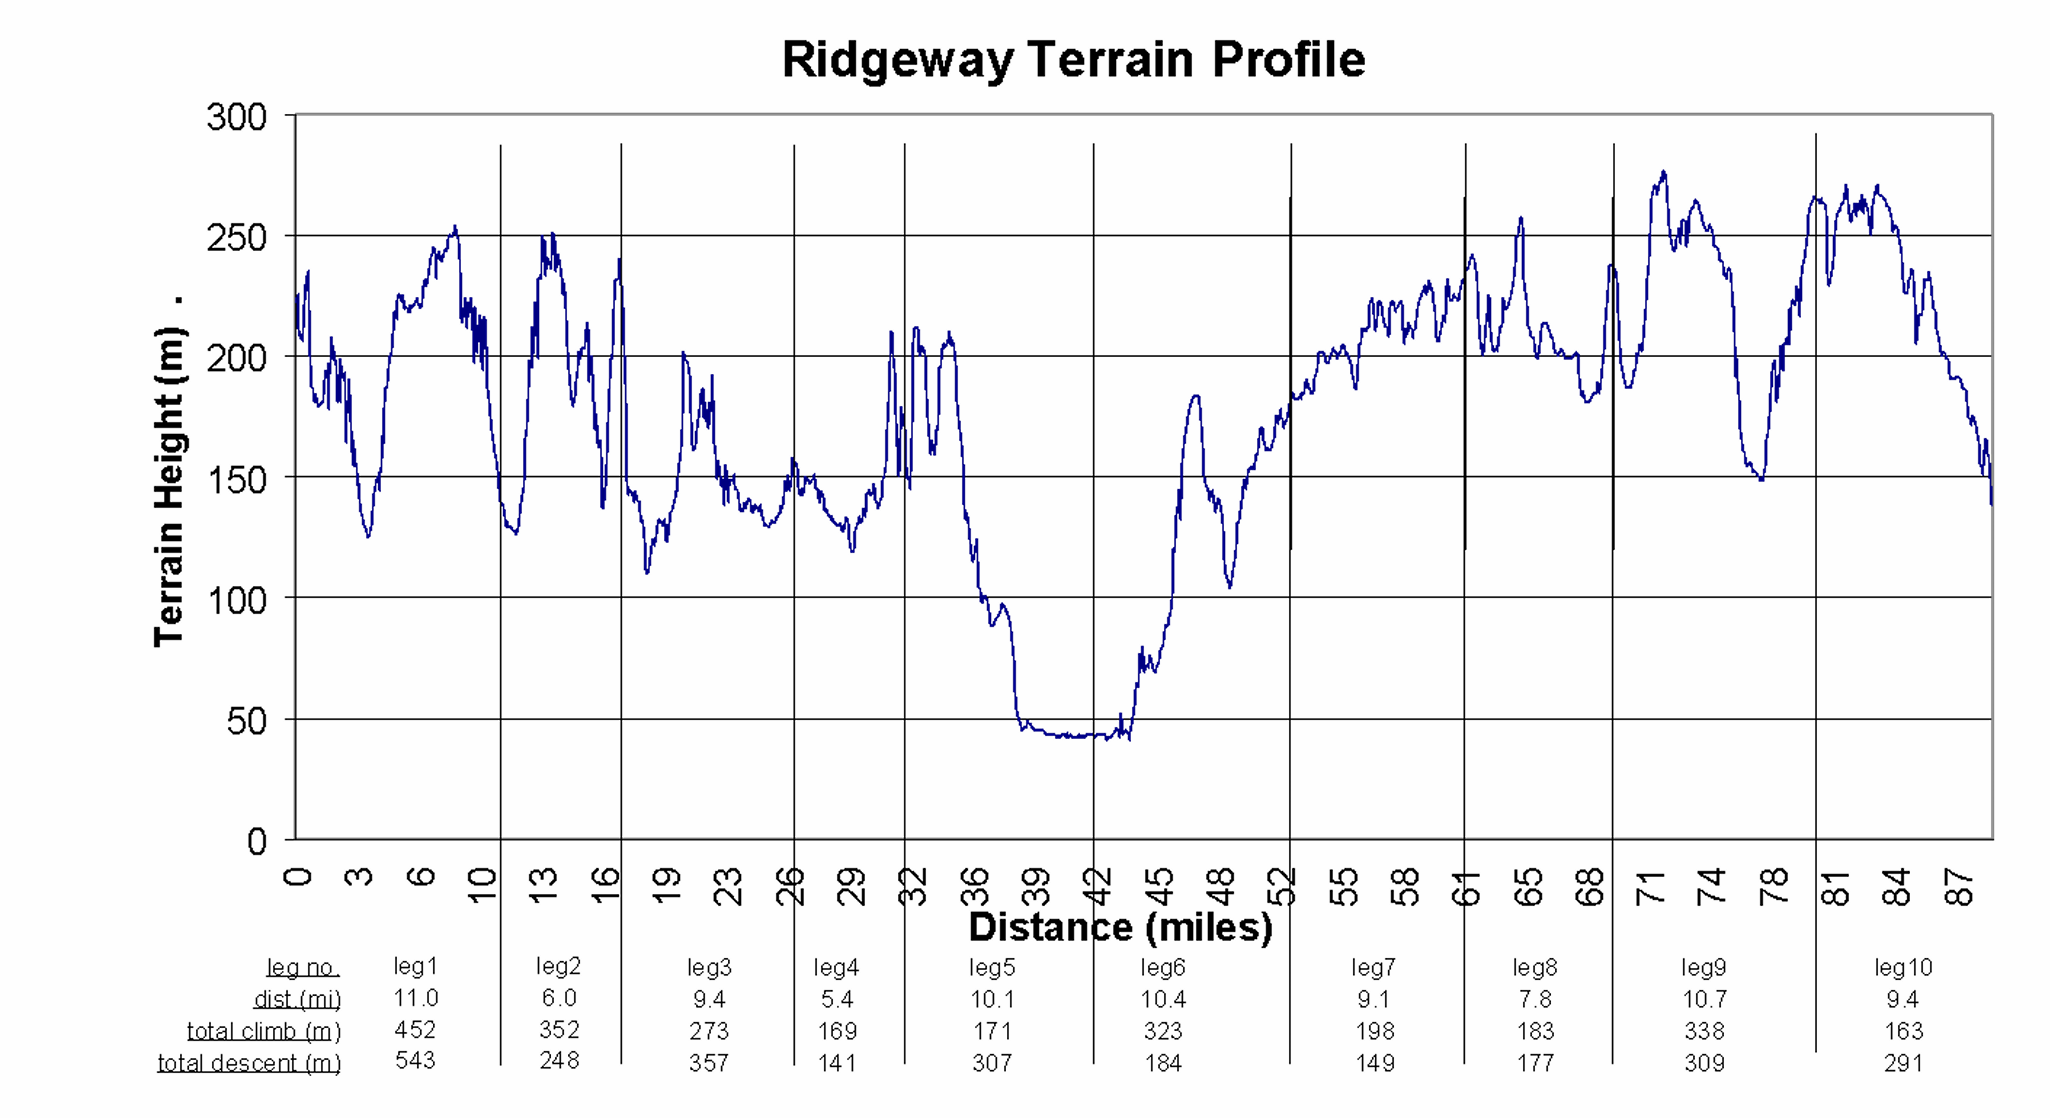